In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import helper
import metrics
import _init_paths
import torch
import torch.utils.data
from opts import opts
from lib.models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
from pytorch_unet_center_wh import train_model
import unet_models
import os,sys
#import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import helper
#import simulation
from tqdm import tqdm
import time
import copy
import numpy as np
import torch
import metrics
from metrics import MetricsCollection
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [2]:
class opts(object):
  def __init__(self):
    self.seed = 327
    self.dataset = 'shape'
    self.task = 'ctdet'
    self.device = 'cuda'
    self.shape_param = ''
    self.shape_param_value = ''
    self.data_dir = '/home/mehdi/CenterNet-master/data'
    self.batch_size = 20
    self.no_color_aug = True
    self.num_workers = 4
    self.keep_res = True
    self.pad = 127
    self.not_rand_crop = True
    self.scale = 0.4
    self.shift = 0.1
    self.flip = 0.5
    self.down_ratio = 4
    self.mse_loss = True
    #self.root_dir = os.path.join(os.path.dirname(__file__), '..', '..')
    #self.data_dir = os.path.join(self.root_dir, 'data')

In [3]:
opt = opts()

In [4]:
def train_model(model, optimizer, lr_scheduler, data_loader, device, max_epochs=100): #loaders
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    has_waited = 0
    stop_training = False
    earlystop_patience = 5

    epoch_metrics = MetricsCollection()

    for epoch in range(max_epochs):
        print('Epoch {}/{}'.format(epoch, max_epochs - 1))
        #print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
        #    if phase == 'train':
        #        model.train()  # Set model to training mode
        #    else:
        #        model.eval()  # Set model to evaluate mode

            batch_metrics = MetricsCollection()

            #########################
            # loader = loaders[phase]
            #pbar = tqdm(data_loader, total=len(data_loader), ncols=0)#, desc="Epoch {} {}".format(epoch, phase)
            for iter_id, batch in enumerate(data_loader): #data_loader


                for k in batch:
                    if k != 'meta':
                        batch[k] = batch[k].to(device=device, non_blocking=True)
                inputs,class_masks,center_masks,width_masks,height_masks =batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap'] # loss_stats
                
                output, losses = model(inputs, class_masks, center_masks, width_masks, height_masks) #batch
                #loss = loss.mean()
                loss = losses['loss']
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            #pbar = tqdm(data_loader, total=len(data_loader), desc="Epoch {} {}".format(epoch, phase), ncols=0)
            # for i, (inputs, class_masks, center_masks, width_masks, height_masks) in enumerate(pbar):
            #########################




                #inputs = inputs.to(device)
                #class_masks = class_masks.to(device)
                #center_masks = center_masks.to(device)
                #width_masks = width_masks.to(device)
                #height_masks = height_masks.to(device)

                #optimizer.zero_grad()

                # compute output
                #with torch.set_grad_enabled(phase == 'train'):
                #    outputs, losses = model(inputs, class_masks, center_masks, width_masks, height_masks)

                #if phase == 'train':
                #    loss = losses['loss']
                #    loss.backward()
                #    optimizer.step()

                for k, v in losses.items():
                    batch_metrics.add(phase, k, v.item())
                #if phase =='train':
                #    pbar.set_postfix(**{k: "{:.5f}".format(meter.avg) for k, meter in batch_metrics[phase].items()})

            for key, meter in batch_metrics[phase].items():
                epoch_metrics.add(phase, key, meter.avg)
                if phase=='train':
                    print('{}_{}'.format(phase, key), meter.avg)

            #if phase == 'val' and (epoch% 10==0):
                # monitor the val metrics
            #    best_epoch_index = epoch_metrics['val']['loss'].best()[1]
           #     if best_epoch_index == epoch:
           #         has_waited = 1
           #         best_model_wts = copy.deepcopy(model.state_dict())
           #         print("Saving the best model state dict")
            #    else:
            #        if has_waited >= earlystop_patience:
            #            print("** Early stop in training: {} waits **".format(has_waited))
             #           stop_training = True

              #      has_waited += 1

              #  if type(lr_scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
              #      lr_scheduler.step(epoch_metrics['val']['loss'].value)
              #  else:
              #      lr_scheduler.step()

        #print()  # end of epoch
        #if stop_training:
        #    break

    #time_elapsed = time.time() - since
    #print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    #load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model, './model_last.pth')
    print ('New model saved!')
    return model



In [5]:

def main():
  torch.manual_seed(opt.seed)
  Dataset = get_dataset(opt.dataset, opt.task)
  
  val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'val'), 
      batch_size=1, 
      shuffle=False,
      num_workers=1,
      pin_memory=True)
      


  train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )
  #Mehdi
  ###############

  import models

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  num_class = Dataset.num_classes #6
  lr_factor = 0.1
  lr_patience = 1
  lr = 1e-4

  modelunet = unet_models.WidthHeightUNet(num_class).to(device)

  optimizer = torch.optim.Adam(modelunet.parameters(), lr=lr)
  lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                            factor=lr_factor,
                                                          patience=lr_patience,
                                                            verbose=True)

  model = train_model(modelunet, optimizer, lr_scheduler, train_loader,device)
  return model  

In [45]:
Dataset.num_classes

AttributeError: type object 'Dataset' has no attribute 'num_classes'

In [6]:
trained_model = main()


==> initializing shapes val data.
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loaded val 700 samples
==> initializing shapes train data.
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loaded train 700 samples
Epoch 0/99


/home/mehdi/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/mehdi/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train_bce_mask 0.6216904363461904
train_dice 0.7464122942515782
train_bce_center 0.09343802056142263
train_dice_center 0.6497677803039551
train_l2_width 0.2874089440064771
train_l2_height 0.2656573780413185
train_loss 2.6643748623984203
Epoch 1/99
train_bce_mask 0.3821137521948133
train_dice 0.5631206810474396
train_bce_center 0.02228834251207965
train_dice_center 0.41525005527905057
train_l2_width 0.02713328863361052
train_l2_height 0.02295912919299943
train_loss 1.4328652552195957
Epoch 2/99
train_bce_mask 0.3433321659054075
train_dice 0.5154808189187731
train_bce_center 0.02087421991995403
train_dice_center 0.4157507402556283
train_l2_width 0.02890252921996372
train_l2_height 0.02632113280040877
train_loss 1.3506616013390678
Epoch 3/99
train_bce_mask 0.2708635981593813
train_dice 0.47200485382761276
train_bce_center 0.019421854029808727
train_dice_center 0.41482920135770524
train_l2_width 0.03779673246400697
train_l2_height 0.034868359459298
train_loss 1.2497845956257412
Epoch 4/99


In [9]:

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    #inp = np.clip(inp, 0, 1)
    #inp = (inp * 255).astype(np.uint8) 
    
    return inp

In [8]:
trained_model = torch.load('model_last.pth')

==> initializing shapes val data.
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loaded val 700 samples


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7efc94377dd8>>
Traceback (most recent call last):
  File "/home/mehdi/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/mehdi/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/mehdi/.pyenv/versions/miniconda3-latest/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/mehdi/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/mehdi/.pyenv/versions/miniconda3-latest/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connec

0
0 0
1
0 0
5
0 5


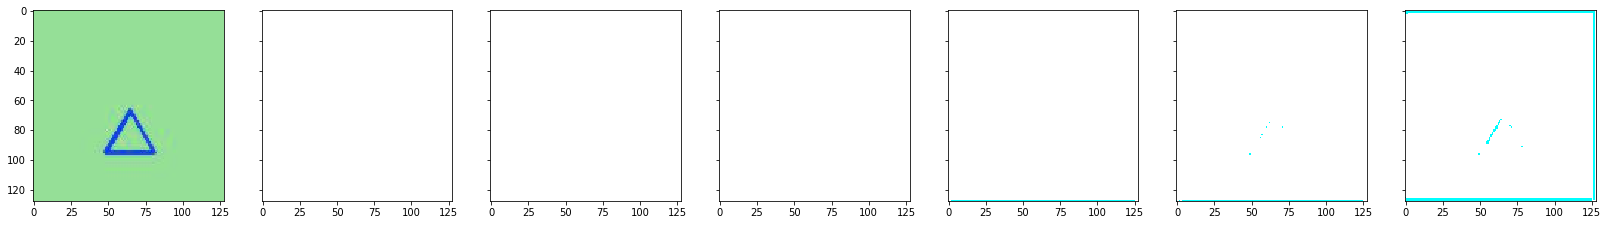

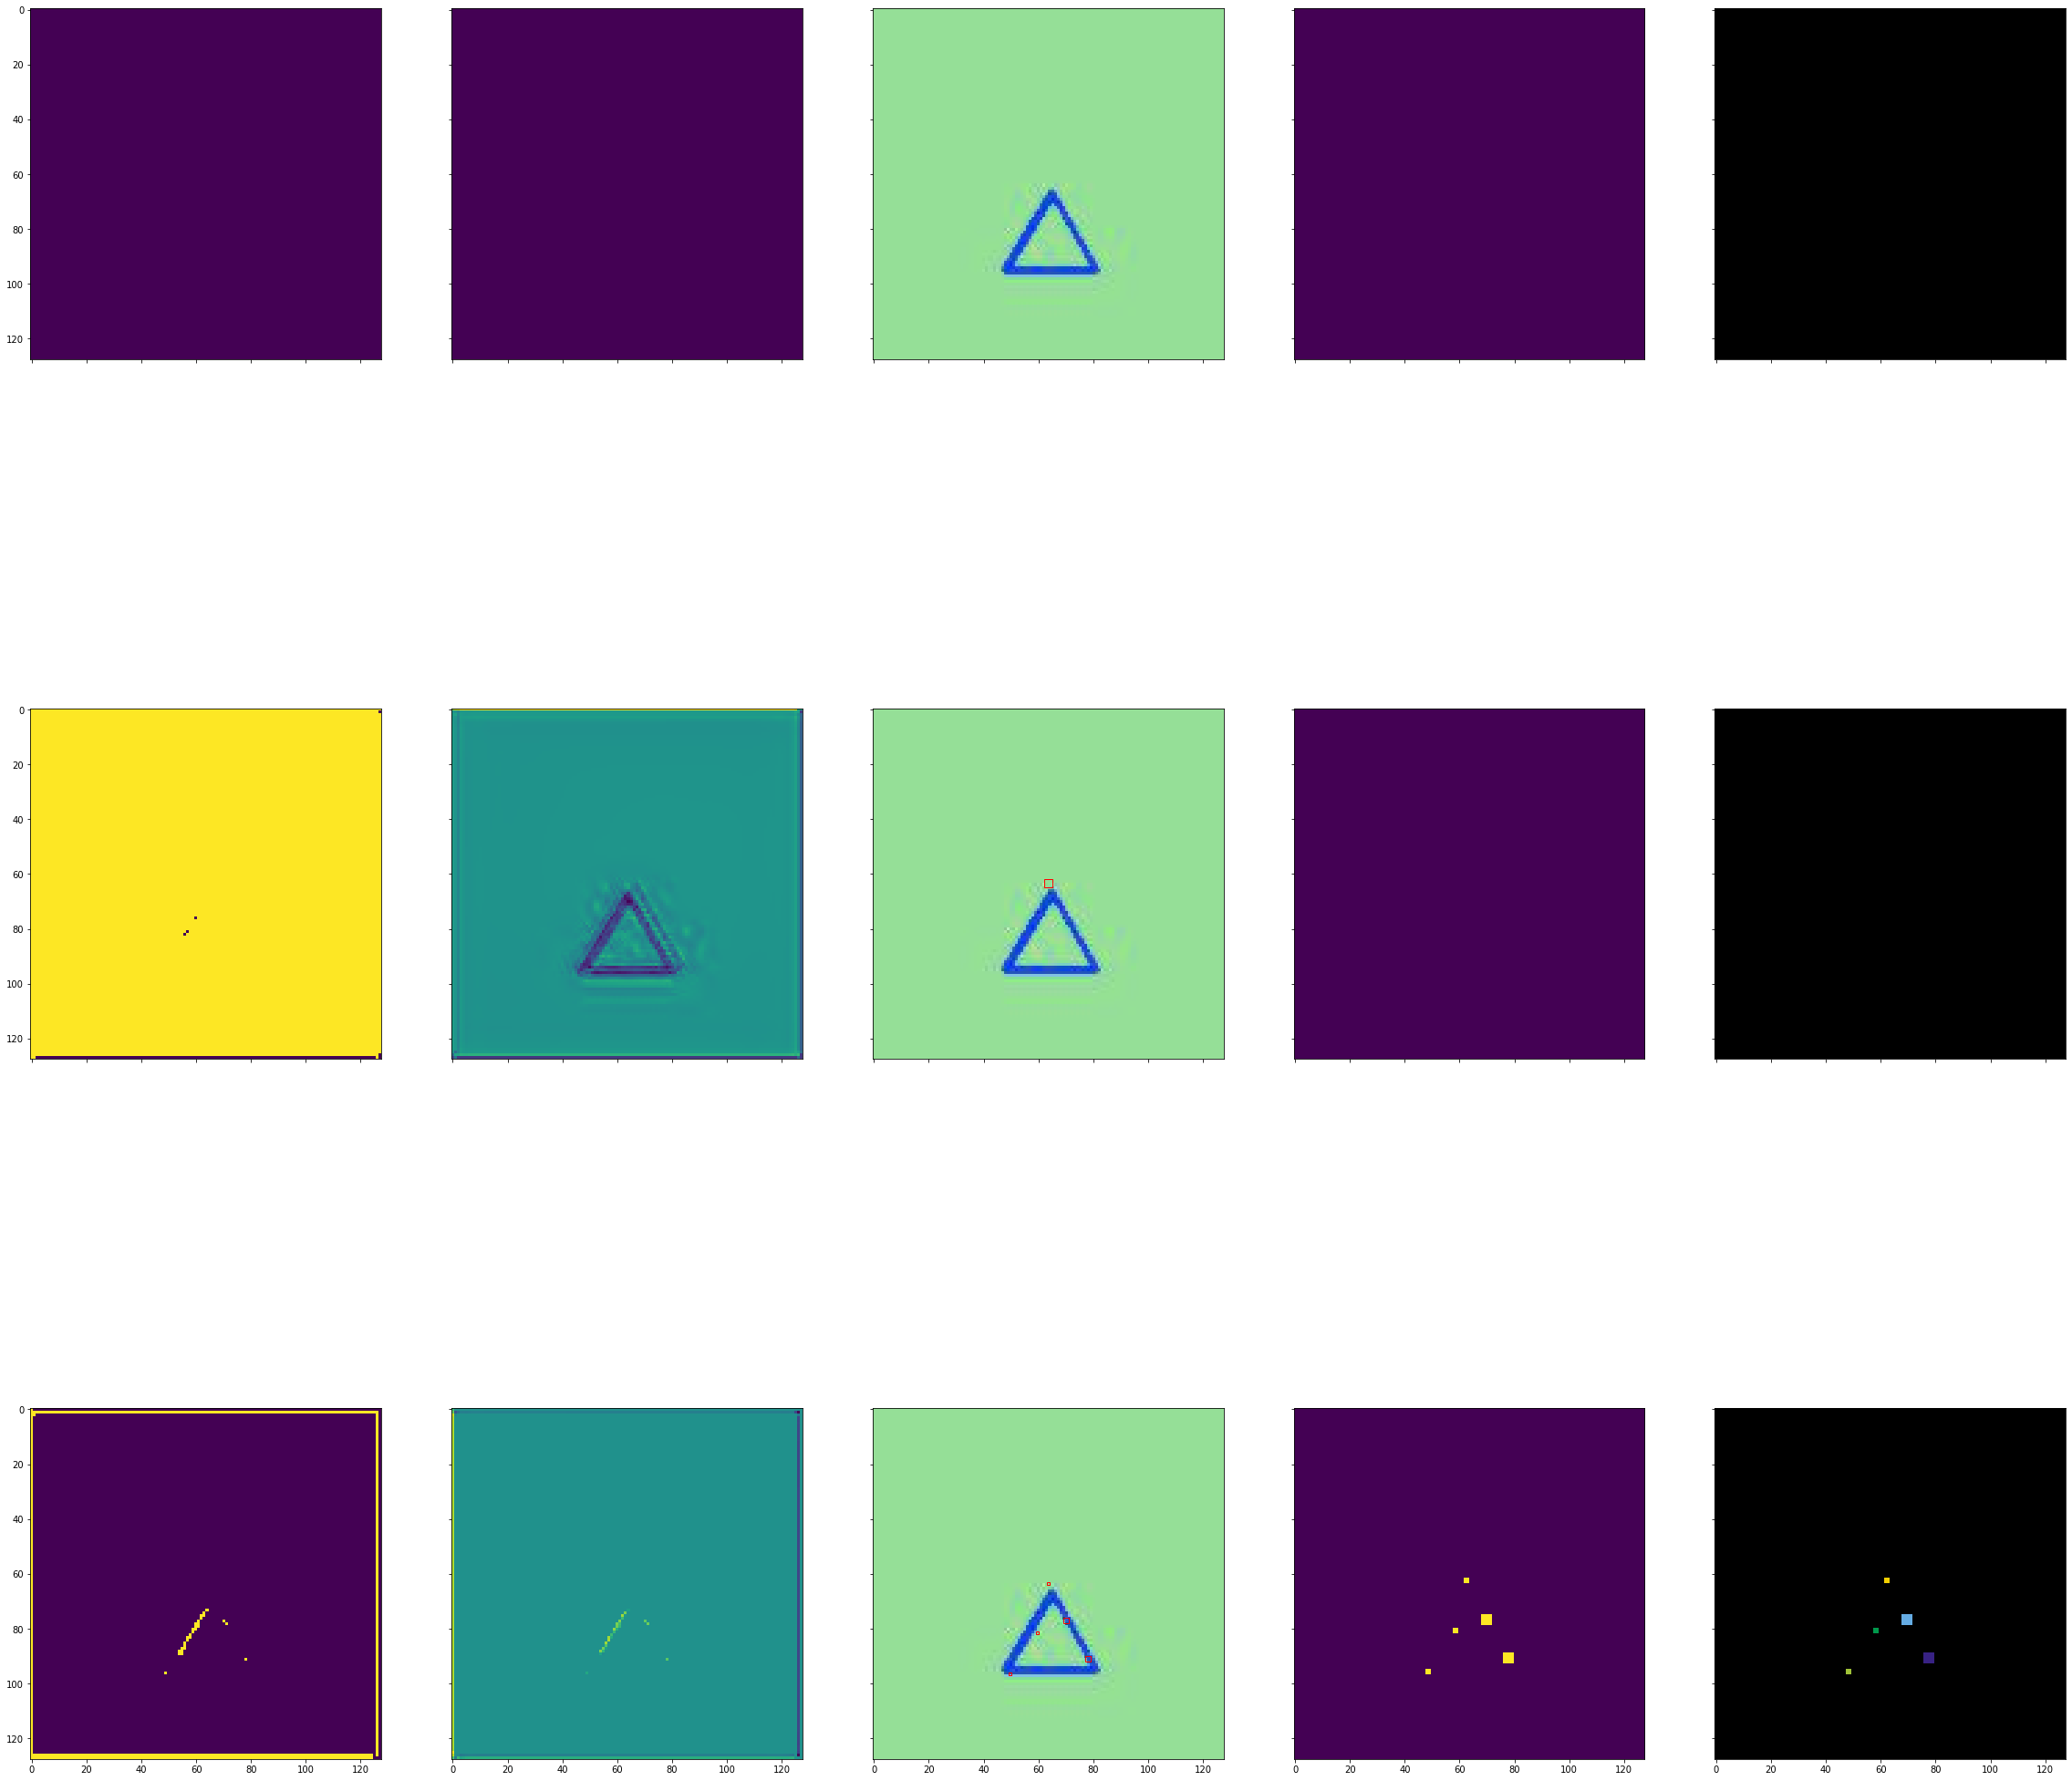

In [13]:
import math
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage.measurements import label  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_class = 3
n_class=3
    
Dataset = get_dataset(opt.dataset, opt.task)
  
val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'val'), 
      batch_size=1, 
      shuffle=True,
      num_workers=1,
      pin_memory=True)

model=trained_model  
    
model.eval()   # Set model to evaluate mode

#test_dataset = SimDataset(1, n_class, transform = trans)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
        
batch  = next(iter(val_loader))
for k in batch:
    if k != 'meta':
        batch[k] = batch[k].to(device=device, non_blocking=True)
inputs, labels_mask, labels_center, labels_width, labels_height  =batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap']

#inputs = inputs.to(device)
# labels_mask = labels_mask.to(device)
# labels_center = labels_center.to(device)

pred = model(inputs, labels_mask, labels_center, labels_width, labels_height )
pred = pred[0]


# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x)/255 for x in inputs.cpu()]


# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x/255, n_class) for x in labels_mask]

# Map each channel (i.e. class) to each color
target_centers_rgb = [helper.masks_to_colorimg(x/255, n_class) for x in labels_center]

for i in [pred]:
    pred_masks = i['class_masks'].data.cpu().numpy()
    pred_centers = i['center_masks'].data.cpu().numpy()
    pred_widths = i['width_masks'].data.cpu().numpy()
    pred_heights = i['height_masks'].data.cpu().numpy()

    mask = pred_centers.copy() 
    mask[mask<0]=0
    mask[mask>0]=1
    
    #import pdb; pdb.set_trace()
    pred_masks_rgb = [helper.masks_to_colorimg(x, n_class) for x in pred_masks]
    pred_centers_rgb = [helper.masks_to_colorimg(x, n_class) for x in mask] # pred_centers
    pred_widths_rgb = [helper.masks_to_colorimg(x, n_class) for x in pred_widths * mask]
    pred_heights_rgb = [helper.masks_to_colorimg(x, n_class) for x in pred_heights * mask]



# Left: Input image, Right: Target mask (Ground-truth)
helper.plot_side_by_side([input_images_rgb, target_masks_rgb, target_centers_rgb, pred_masks_rgb, pred_centers_rgb, pred_widths_rgb, pred_heights_rgb])


# -------

inp = np.copy(inputs.cpu())
img = np.copy(inp[0])
# img = img.reshape((192,192,3))
img = np.transpose(img,[1,2,0])/255
# img = img(:,:,[0])




f, plots = plt.subplots(n_class, 5, sharex='all', sharey='all', figsize=(4 * 10, 4 * 10))


for i in range(n_class):
    a2 = np.copy(pred_centers[0,i,:,:])
    a2[a2<0]=0
    a2[a2>0]=1
    plots[i,0].imshow(a2)

    a4 = np.copy(pred_widths[0,i,:,:])     
    a4 = a4*a2 #.numpy()
    plots[i,1].imshow(a4)



# finding connected components
    from scipy.ndimage.measurements import label  
    structure = np.ones((3, 3), dtype=np.int)
    labeled, ncomponents = label(a4, structure)
    indices = np.indices(a4.shape).T[:,:,[1, 0]]

    ax = plots[i,2] #plt.subplots(1)
    ax.imshow(img)
    coords = []
    for c in range(ncomponents):
        a = indices[labeled == c+1]
        x, y = (np.min(a[:,0]) + np.max(a[:,0]))//2, (np.min(a[:,1]) + np.max(a[:,1]))//2
        w, h = int(a4[x,y])+1, int(a4[x,y])+1
        coords.append( (x, y , w, h) )    
        rect = patches.Rectangle((y-w//2, x-h//2), w, h, linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)


    print(len(coords))

    semantic_mask = np.zeros(pred_masks.shape[2:])
    pred_masks_class = pred_masks[0,i,...]
    pred_masks_class[pred_masks_class<0] = 0 #pred_masks_class
    pred_masks_class[pred_masks_class>0] = 1

    for box in coords:
        x, y, w, h = box
        w , h = w//2+1, h//2+1
        semantic_mask[x-w:x+w, y-h:y+h]  = 1
    plots[i,3].imshow(pred_masks_class* semantic_mask ) #


    instance_mask = np.zeros(pred_masks.shape[2:])
    pred_masks_class = pred_masks[0,i,...]
    pred_masks_class[pred_masks_class<0] = 0
    pred_masks_class[pred_masks_class>0] = 1
    xx = np.zeros(pred_masks.shape[2:], dtype=np.int)
    cc = 1
    for box in coords:
        x, y, w, h = box
        w , h = w//2+1, h//2+1
        instance_mask = np.zeros(pred_masks.shape[2:])
        instance_mask[x-w:x+w, y-h:y+h]  = 1
        mm = np.zeros(pred_masks.shape[2:], dtype=np.int)
        mm = pred_masks_class.astype(int) * instance_mask.astype(int) 
        mm = mm * cc
        xx = xx + mm
        xx[xx>cc] = cc
        cc += 1

#     xx = np.reshape(xx, [1,xx.shape[0], xx.shape[1]])
#     xx = xx[0,0,:,:]
    xx = xx.astype(int)
    print(np.min(xx), np.max(xx))
    plots[i,4].imshow(helper.masks_to_colorimg3(xx))

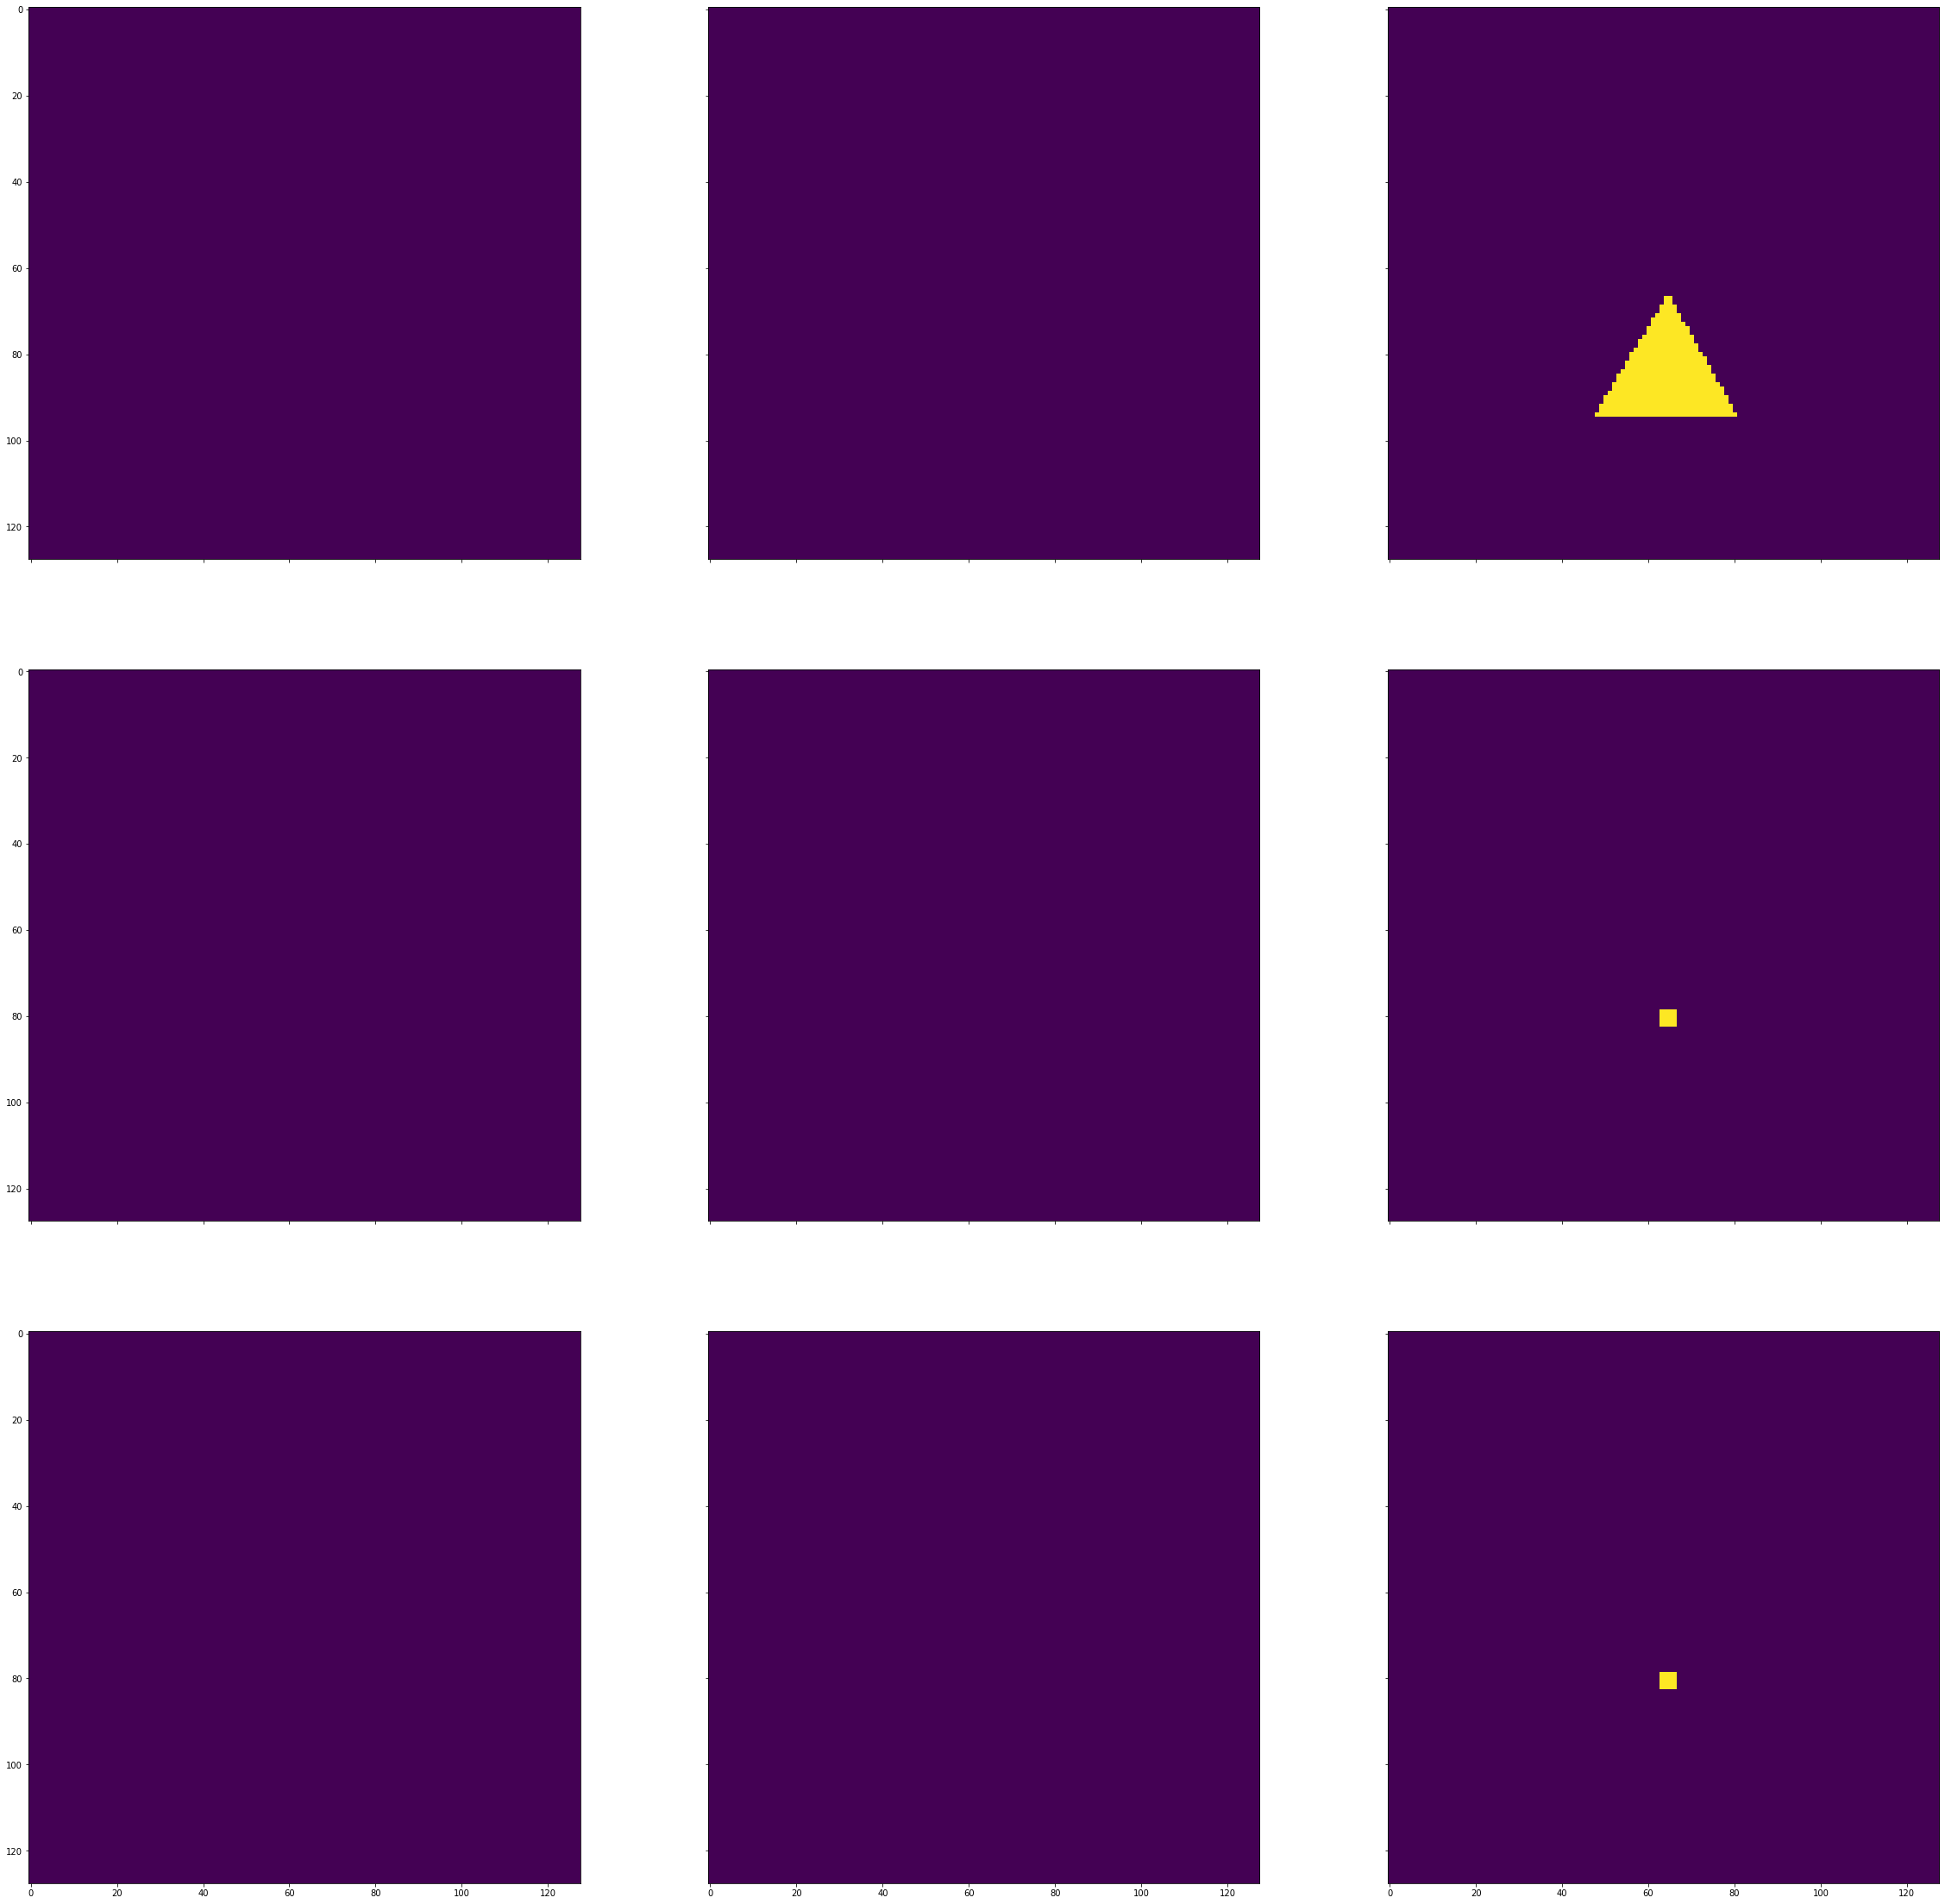

In [14]:
f, plots = plt.subplots(3, 3, sharex='all', sharey='all', figsize=(4 * 10, 4 * 10))
for i in range(n_class):
   # plt.figure()
    plots[0,i].imshow(labels_mask[0,i])
    plots[1,i].imshow(labels_center[0,i])
    plots[2,i].imshow(labels_width[0,i])

    


In [48]:
pred_masks.shape[2:]


(128, 128)

In [4]:
#plt.imshow(pred_masks[0].transpose((1, 2, 0)))
import math
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage.measurements import label  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_class = 3
n_class=3
    
Dataset = get_dataset(opt.dataset, opt.task)
  
val_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'val'), 
      batch_size=1, 
      shuffle=True,
      num_workers=1,
      pin_memory=True)
batch  = next(iter(val_loader))
for k in batch:
    if k != 'meta':
        batch[k] = batch[k].to(device=device, non_blocking=True)
inputs, labels_mask, labels_center, labels_width, labels_height  =batch['input'],batch['gt_segmap'], batch['gt_ctmap'], batch['gt_widmap'], batch['gt_heimap']

k =1
plt.imshow(pred_masks[0,k])

==> initializing shapes val data.
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loaded val 700 samples


NameError: name 'pred_masks' is not defined

In [16]:
k = 3
plt.imshow(inputs[0,k])

IndexError: index 3 is out of bounds for dimension 0 with size 3

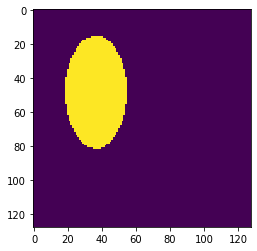

In [26]:
k = 4
plt.imshow(labels_mask[0,k])

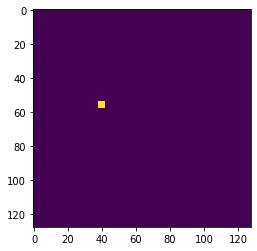

In [28]:
k=3
plt.imshow(labels_height[0,k])


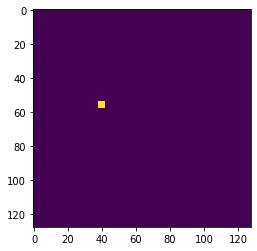

In [32]:
k = 3
plt.imshow(labels_width[0,k])

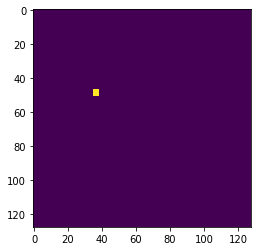

In [31]:
k = 4
plt.imshow(labels_center[0,k])

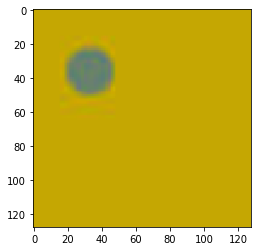

In [131]:
plt.figure()
#plt.imshow(reverse_transform(inputs[0].cpu()))
#plt.imshow(reverse_transform(labels_mask[0].cpu()))
#plt.imshow(reverse_transform(labels_center[0].cpu()))
#plt.imshow(reverse_transform(labels_width[0].cpu()))
#plt.imshow(reverse_transform(labels_height[0].cpu()))
plt.imshow(inputs[0].cpu().numpy().transpose((1, 2, 0))/255) #.dtype

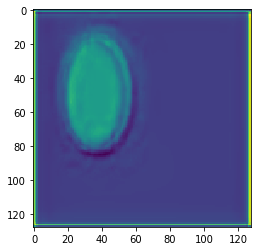

In [37]:
k = 4
plt.imshow(pred_widths[0,k])

In [59]:
l.shape

(1, 5, 128, 128)

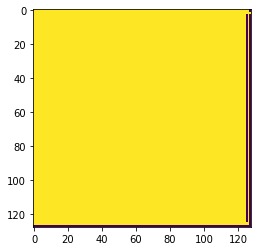

In [45]:
plt.imshow(pred_masks[0,4])